In [1]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
classification_report
from sklearn.neighbors import KNeighborsClassifier


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE+2)  # fontsize of the figure title

np.random.seed(1000)

trainval_ratio = 0.80
test_ratio = 0.20

In [2]:
from shutil import copyfile
copyfile(src = "../input/helpers/my_one_hot_encoder.py", dst = "../working/my_one_hot_encoder.py")
from my_one_hot_encoder import *

In [3]:

data = pd.read_csv('../input/dataset/data_small.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (47,48,473,475,476,489,490,491,492,493,494,495,496,497,498,499,500,501) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
headers = data.columns.values
data.tail()

,Unnamed: 0,Unnamed: 0.1,RID,PTID,VISCODE,SITE,D1,D2,COLPROT,ORIGPROT,...,ST102TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST102TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
8315,12726,12726,1023,036_S_1023,m108,36,1,1,ADNI2,ADNI1,...,,,,,,,,,,
8316,12730,12730,296,100_S_0296,m120,100,1,1,ADNI2,ADNI1,...,,,,,,,,,,
8317,12731,12731,1286,100_S_1286,m108,100,1,1,ADNI2,ADNI1,...,,,,,,,,,,
8318,12733,12733,2061,035_S_2061,m72,35,1,1,ADNI2,ADNIGO,...,,,,,,,,,,
8319,12734,12734,4556,100_S_4556,m48,100,1,1,ADNI2,ADNI2,...,,,,,,,,,,


In [5]:
# Transforming 'VISCODE' to meaningful numeric data (VIS).

data['VIS'] = [0 if vis=="bl" else vis[1:] for vis in data['VISCODE']]
data['VIS'] = pd.to_numeric(data['VIS'])
data.VIS.head()

0     0
1     0
2     6
3    12
4    24
Name: VIS, dtype: int64

In [6]:
# Filtering the needed subset for prediction.

datap1 = data.query('VISCODE == "bl" and (DXCHANGE == 1 or DXCHANGE == 3)')
datap1.drop(columns=['VISCODE'], inplace=True)
datap1.DXCHANGE.value_counts()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1.0    521
3.0    336
Name: DXCHANGE, dtype: int64

In [7]:

# Checking the number of null values in each of the columns.

null_columns = datap1.columns[datap1.isnull().any()]
datap1[null_columns].isnull().sum()

APOE4                                             3
FDG                                             224
PIB                                             852
AV45                                            426
ADAS11                                            2
                                               ... 
INSULAQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16      1
OCCQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16         1
BGQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16          1
CWMQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16         1
VENTQC_UCSFFSX_11_02_15_UCSFFSX51_08_01_16        1
Length: 89, dtype: int64

In [8]:
interested_columns = ['DXCHANGE','RID','PTID','EXAMDATE','AGE','PTGENDER','PTEDUCAT','PTMARRY','APOE4','CDRSB',\
                     'ADAS11','ADAS13','MMSE','RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting',\
                     'FAQ','MOCA','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','FDG','PIB',\
                     'AV45']
datap1[interested_columns].isnull().sum()

DXCHANGE                   0
RID                        0
PTID                       0
EXAMDATE                   0
AGE                        0
PTGENDER                   0
PTEDUCAT                   0
PTMARRY                    0
APOE4                      3
CDRSB                      0
ADAS11                     2
ADAS13                     8
MMSE                       0
RAVLT_immediate            5
RAVLT_learning             5
RAVLT_forgetting           5
RAVLT_perc_forgetting      9
FAQ                        1
MOCA                     425
Ventricles                48
Hippocampus              112
WholeBrain                28
Entorhinal               133
Fusiform                 133
MidTemp                  133
ICV                        7
FDG                      224
PIB                      852
AV45                     426
dtype: int64

In [9]:
datap1pred = datap1[['PTGENDER','PTMARRY','AGE','PTEDUCAT','APOE4','CDRSB','ADAS11','ADAS13','MMSE', \
                       'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ', \
                       'Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','DXCHANGE']]
datap1pred.reset_index(inplace = True, drop=True)
num_imp = IterativeImputer(max_iter=20).fit_transform(datap1pred.select_dtypes(exclude=[object]))
datap1predi = pd.concat([datap1pred.select_dtypes(include=[object]), pd.DataFrame(num_imp)], axis=1)
datap1predi.columns = datap1pred.columns

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


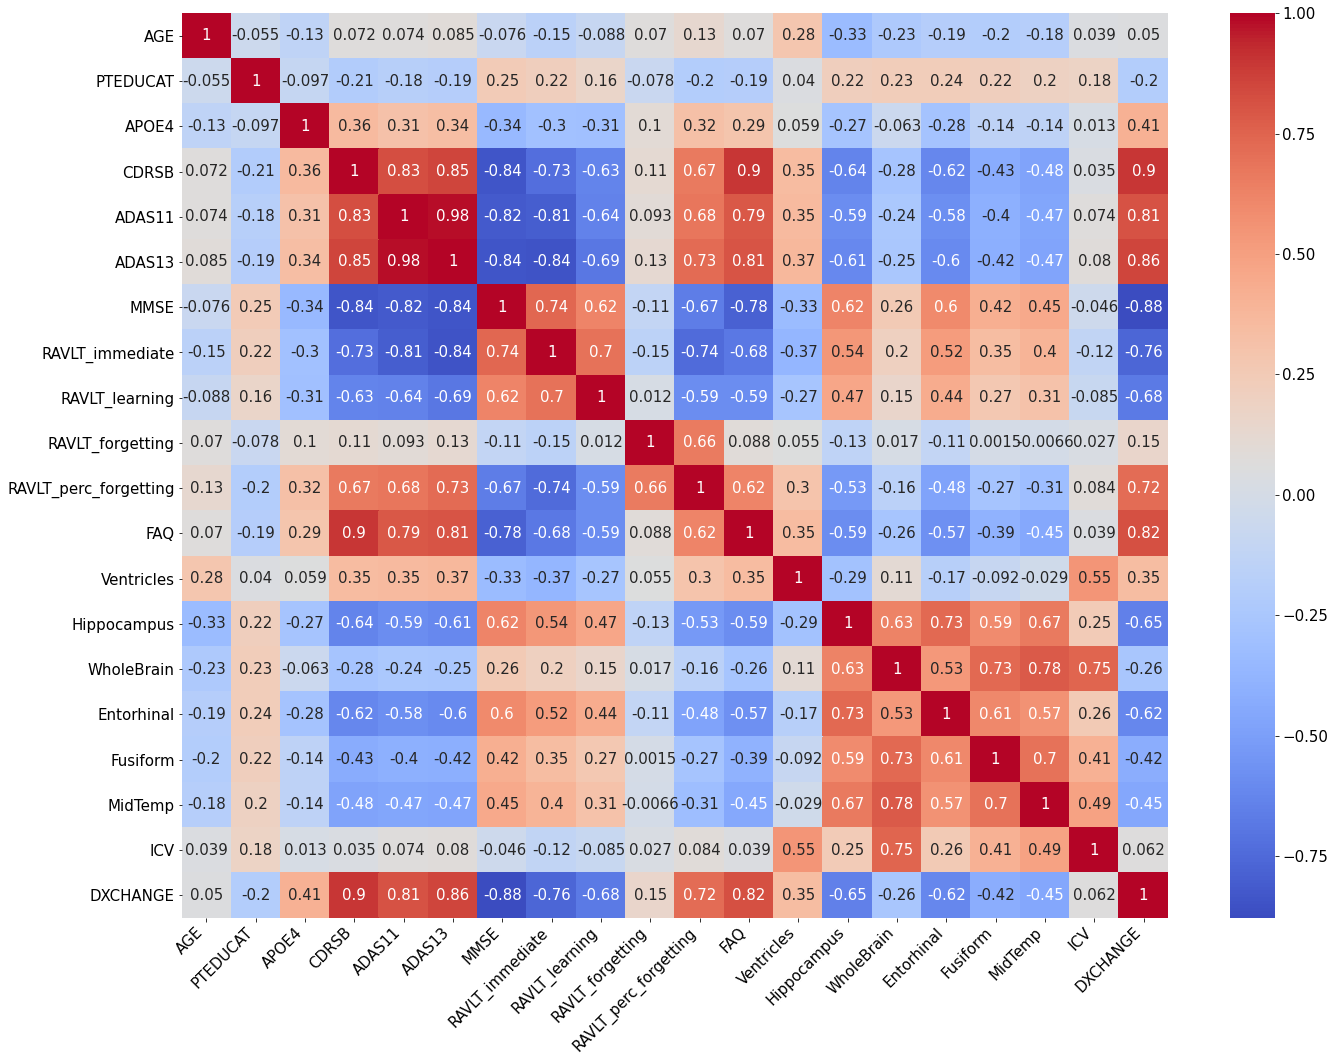

In [10]:
# Finding correlation between the features.

corr = datap1predi.corr()

plt.figure(figsize=(20,15))
ax = sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt='.2g'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
);
plt.tight_layout()

In [11]:
# Preserving the information about which values had been missing can be informative. 
datap1predic = datap1predi.copy()
cols_with_missing = (col for col in datap1pred.columns 
                                 if datap1pred[col].isnull().any())
for col in cols_with_missing:
    datap1predic[col + '_was_missing'] = datap1predic[col].isnull().astype('int64')

In [12]:
ind = datap1predic.select_dtypes(include=[object]).columns

onehotpt1 = datap1predic
for i in ind:
    onehotpt1 = MyOneHotEncoder().encodePandasColAndMerge(data_frame = onehotpt1, col_name = i)

In [13]:
# Shuffle (1st time).
shufdata = onehotpt1.sample(frac=1)
x_data = shufdata[shufdata.columns.difference(['DXCHANGE'])]
y_data = shufdata[['DXCHANGE']]


# Here, the 'x_train' subset contains the validation set as we would be performing 5-fold cross validation.
x_train, x_test, y_un_train, y_un_test = train_test_split(x_data, y_data, \
                                                    test_size=1 - trainval_ratio, stratify=y_data)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

# Using ravel() to flatten the column
y_train = y_un_train.values.ravel()
y_test = y_un_test.values.ravel()

In [14]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

logreg = LogisticRegression()
scores_val = cross_validate(logreg, x_train_sc, y_train, cv=5, scoring=scoring)
print("5 fold Logistic Regression F1 Score: {}".format(scores_val['test_f1_score'].mean()))

5 fold Logistic Regression F1 Score: 0.996392756655364


Accuracy of logistic regression classifier on test set: 0.994186

Since the class distribution is unbalanced in the dataset, let us find F1 score to judge the model
F1 Score of logistic regression classifier on test set: 0.995261

Classification Report: 
               precision    recall  f1-score   support

         1.0       0.99      1.00      1.00       105
         3.0       1.00      0.99      0.99        67

    accuracy                           0.99       172
   macro avg       1.00      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172



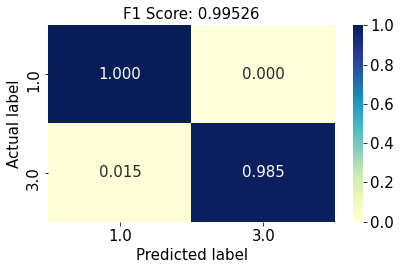

In [15]:
#no hyper parameter tuning 

logreg.fit(x_train_sc, y_train)
y_pred = logreg.predict(x_test_sc)
score_test = logreg.score(x_test_sc, y_test)
print('Accuracy of logistic regression classifier on test set: {:.6f}'.format(score_test),end='\n'*2)
print('Since the class distribution is unbalanced in the dataset, let us find F1 score to judge the model')

f1 = f1_score(y_test, y_pred)
print('F1 Score of logistic regression classifier on test set: {:.6f}'.format(f1))

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print("\nClassification Report: \n",cr)

cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn = pd.DataFrame(cm_n, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure()
sns.heatmap(cmn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('F1 Score: %.5f' %f1)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
#plt.savefig('sav_images/p1confusion_matrix_logreg.svg',transparent=True)
plt.show()

Neighbor which gives the best F1 score (through 5 fold CV) = 23
F1 Score of KNN classifier on test set: 0.990566

Classification Report: 
               precision    recall  f1-score   support

         1.0       0.98      1.00      0.99       105
         3.0       1.00      0.97      0.98        67

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172



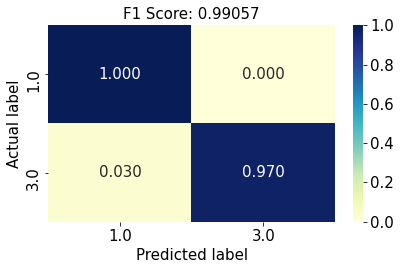

In [16]:
# KNN Classifier.

knn = KNeighborsClassifier()
krange = np.arange(1, 151)
param_grid_knn = {'n_neighbors': krange}
knn_gscv = GridSearchCV(knn, param_grid_knn, scoring=('f1'), cv=5)
knn_gscv.fit(x_train_sc, y_train)
print("Neighbor which gives the best F1 score (through 5 fold CV) = {}".format(knn_gscv.best_params_['n_neighbors']))

y_pred_knn = knn_gscv.predict(x_test_sc)

f1_knn= f1_score(y_test, y_pred_knn)
print('F1 Score of KNN classifier on test set: {:.6f}'.format(f1_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
cr_knn = classification_report(y_test, y_pred_knn)
print("\nClassification Report: \n",cr_knn)

cm_knn_n = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
cmn_knn = pd.DataFrame(cm_knn_n, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure()
sns.heatmap(cmn_knn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('F1 Score: %.5f' %f1_knn)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.show()

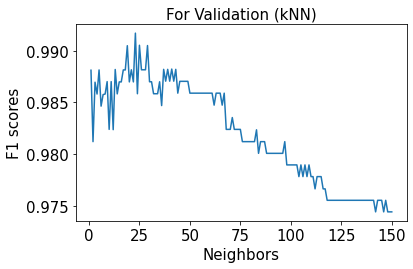

In [17]:


plt.figure()
plt.ylabel('F1 scores');
plt.xlabel('Neighbors');
all_sample_title = ('For Validation (kNN)')
plt.plot(krange,knn_gscv.cv_results_['mean_test_score'])
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
#plt.savefig('sav_images/p1knn.svg',transparent=True)
plt.show()

**Logistic Regression is slightly better than K-NN for this particular task (on this dataset and ) in terms of prediction. But, the difference isn't significant enough to say that one is better than the other for this task.**

**AD versus CN versus MCI at baseline**

In [18]:

# To make things look nicer and easy to interpret, I might use the same variable names as in Part 1 for Part 2.

input("Press Enter to continue...")

# So, cleearing the variables.
%reset -f

Press Enter to continue...


In [19]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
classification_report
from sklearn.neighbors import KNeighborsClassifier

#from helpers.my_one_hot_encoder import MyOneHotEncoder

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE+2)  # fontsize of the figure title

np.random.seed(1000)

trainval_ratio = 0.80
test_ratio = 0.20

In [20]:
from shutil import copyfile
copyfile(src = "../input/helpers/my_one_hot_encoder.py", dst = "../working/my_one_hot_encoder.py")
from my_one_hot_encoder import *

In [21]:
data = pd.read_csv('../input/dataset/data_small.csv')
data.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

data['VIS'] = [0 if vis=="bl" else vis[1:] for vis in data['VISCODE']]
data['VIS'] = pd.to_numeric(data['VIS'])

datap1 = data.query('VISCODE == "bl"')
datap1.drop(columns=['VISCODE'], inplace=True)
datap1.DXCHANGE.value_counts()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (47,48,473,475,476,489,490,491,492,493,494,495,496,497,498,499,500,501) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


2.0    864
1.0    521
3.0    336
Name: DXCHANGE, dtype: int64

In [22]:
interested_columns = ['DXCHANGE','RID','PTID','EXAMDATE','AGE','PTGENDER','PTEDUCAT','PTMARRY','APOE4','CDRSB',\
                     'ADAS11','ADAS13','MMSE','RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting',\
                     'FAQ','MOCA','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','FDG','PIB',\
                     'AV45']
datap1[interested_columns].isnull().sum()

DXCHANGE                    0
RID                         0
PTID                        0
EXAMDATE                    0
AGE                         0
PTGENDER                    0
PTEDUCAT                    0
PTMARRY                     0
APOE4                       6
CDRSB                       0
ADAS11                      3
ADAS13                     12
MMSE                        0
RAVLT_immediate             5
RAVLT_learning              5
RAVLT_forgetting            5
RAVLT_perc_forgetting      10
FAQ                         5
MOCA                      825
Ventricles                 79
Hippocampus               242
WholeBrain                 45
Entorhinal                265
Fusiform                  265
MidTemp                   265
ICV                        13
FDG                       425
PIB                      1701
AV45                      833
dtype: int64

In [23]:
datap1pred = datap1[['PTGENDER','PTMARRY','AGE','PTEDUCAT','APOE4','CDRSB','ADAS11','ADAS13','MMSE', \
                       'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ', \
                       'Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','DXCHANGE']]
datap1pred.reset_index(inplace = True, drop=True)
num_imp = IterativeImputer(max_iter=20).fit_transform(datap1pred.select_dtypes(exclude=[object]))
datap1predi = pd.concat([datap1pred.select_dtypes(include=[object]), pd.DataFrame(num_imp)], axis=1)
datap1predi.columns = datap1pred.columns

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


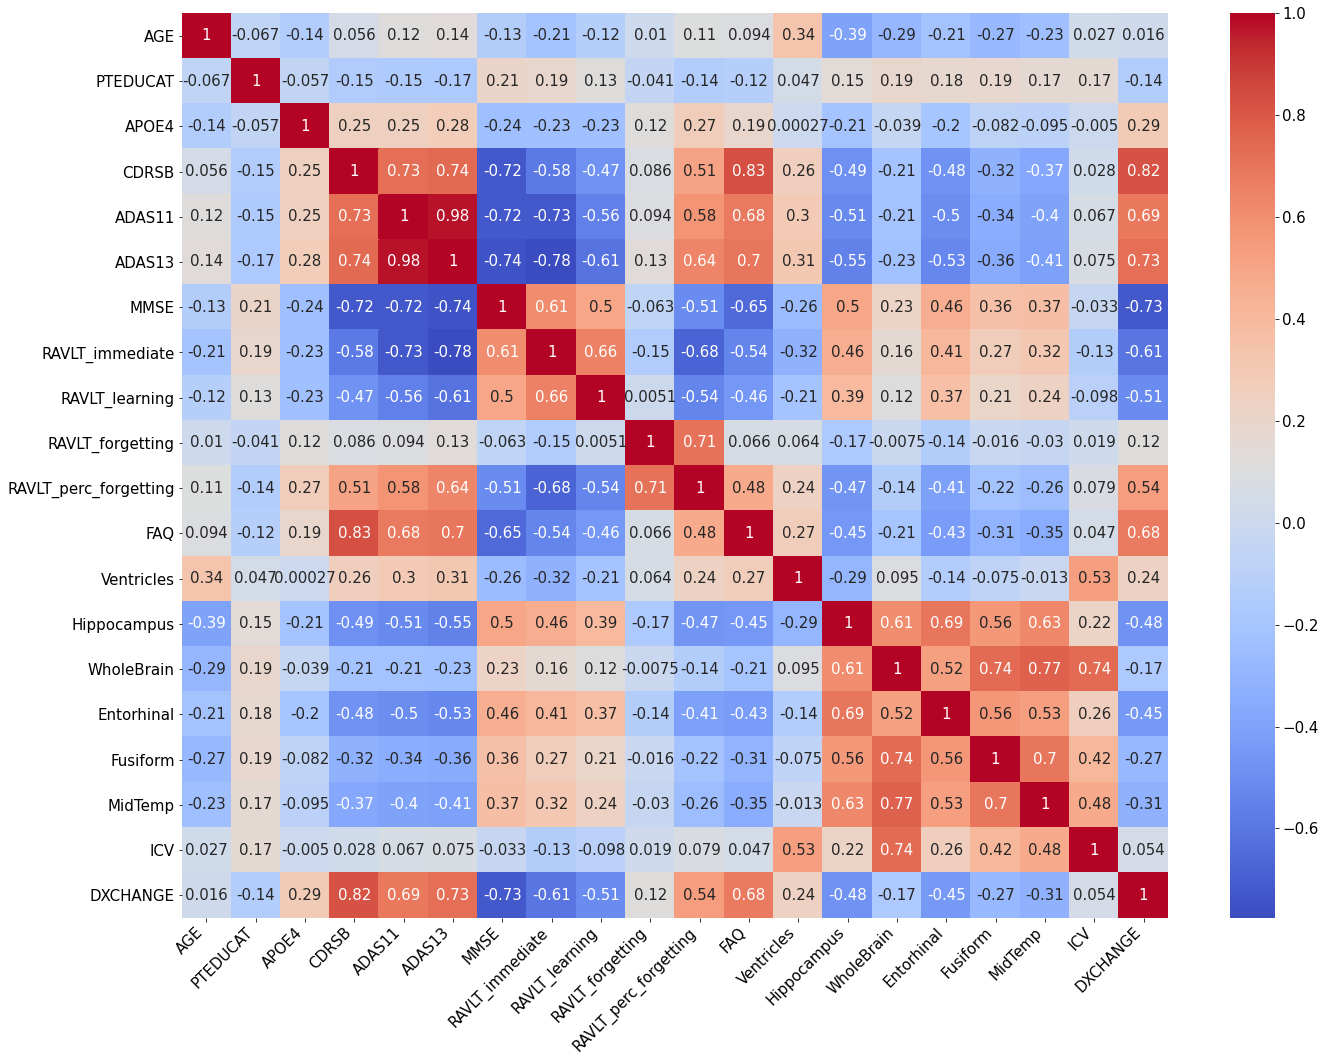

In [24]:
corr = datap1predi.corr()

plt.figure(figsize=(20,15))
ax = sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt='.2g'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
);
plt.tight_layout()

In [26]:
# the pre-process steps which has already been explained in Part1.

datap1predic = datap1predi.copy()
cols_with_missing = (col for col in datap1pred.columns 
                                 if datap1pred[col].isnull().any())
for col in cols_with_missing:
    datap1predic[col + '_was_missing'] = datap1predic[col].isnull().astype('int64')

ind = datap1predic.select_dtypes(include=[object]).columns

onehotpt1 = datap1predic
for i in ind:
    onehotpt1 = MyOneHotEncoder().encodePandasColAndMerge(data_frame = onehotpt1, col_name = i)

In [29]:
# Shuffle (1st time).
shufdata = onehotpt1.sample(frac=1)
x_data = shufdata[shufdata.columns.difference(['DXCHANGE'])]
y_data = shufdata[['DXCHANGE']]

# Shuffle and stratified to care of class ratios.
# Here, the 'x_train' subset contains the validation set as we would be performing 5-fold cross validation.
x_train, x_test, y_un_train, y_un_test = train_test_split(x_data, y_data, \
                                                    test_size=1 - trainval_ratio, stratify=y_data)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

# Using ravel() to flatten the column
y_train = y_un_train.values.ravel()
y_test = y_un_test.values.ravel()

In [30]:
scoring = {'f1_score' : make_scorer(f1_score, average='micro')}

logreg = LogisticRegression()
scores_val = cross_validate(logreg, x_train_sc, y_train, cv=5, scoring=scoring)
print("5 fold Logistic Regression F1 Score: {}".format(scores_val['test_f1_score'].mean()))

5 fold Logistic Regression F1 Score: 0.9265876152832675


Accuracy of logistic regression classifier on test set: 0.924638

Since the class distribution is different in the dataset, let us find F1 score to judge the model
F1 Score of logistic regression classifier on test set: 0.924638

Classification Report: 
               precision    recall  f1-score   support

         1.0       0.97      0.92      0.95       105
         2.0       0.92      0.93      0.93       173
         3.0       0.87      0.91      0.89        67

    accuracy                           0.92       345
   macro avg       0.92      0.92      0.92       345
weighted avg       0.93      0.92      0.92       345



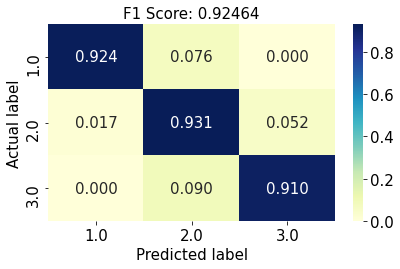

In [31]:
logreg.fit(x_train_sc, y_train)
y_pred = logreg.predict(x_test_sc)
score_test = logreg.score(x_test_sc, y_test)
print('Accuracy of logistic regression classifier on test set: {:.6f}'.format(score_test),end='\n'*2)
print('Since the class distribution is different in the dataset, let us find F1 score to judge the model')

f1 = f1_score(y_test, y_pred, average='micro')
print('F1 Score of logistic regression classifier on test set: {:.6f}'.format(f1))

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print("\nClassification Report: \n",cr)

cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn = pd.DataFrame(cm_n, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure()
sns.heatmap(cmn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('F1 Score: %.5f' %f1)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
#plt.savefig('sav_images/p2confusion_matrix_logreg.svg',transparent=True)
plt.show()

Neighbor which gives the best F1 score (through 5 fold CV) = 25
F1 Score of KNN classifier on test set: 0.834783

Classification Report: 
               precision    recall  f1-score   support

         1.0       0.77      0.84      0.80       105
         2.0       0.84      0.83      0.83       173
         3.0       0.97      0.84      0.90        67

    accuracy                           0.83       345
   macro avg       0.86      0.84      0.84       345
weighted avg       0.84      0.83      0.84       345



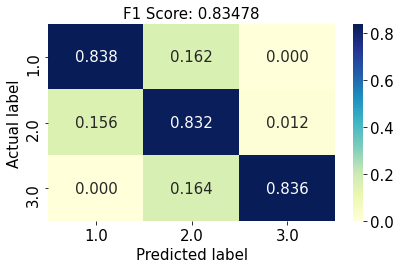

In [32]:
#  KNN Classifier.

knn = KNeighborsClassifier()
krange = np.arange(1, 151)
param_grid_knn = {'n_neighbors': krange}
knn_gscv = GridSearchCV(knn, param_grid_knn, scoring='f1_micro', cv=5)
knn_gscv.fit(x_train_sc, y_train)
print("Neighbor which gives the best F1 score (through 5 fold CV) = {}".format(knn_gscv.best_params_['n_neighbors']))

y_pred_knn = knn_gscv.predict(x_test_sc)

f1_knn= f1_score(y_test, y_pred_knn, average='micro')
print('F1 Score of KNN classifier on test set: {:.6f}'.format(f1_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
cr_knn = classification_report(y_test, y_pred_knn)
print("\nClassification Report: \n",cr_knn)

cm_knn_n = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
cmn_knn = pd.DataFrame(cm_knn_n, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure()
sns.heatmap(cmn_knn, annot=True, fmt='.3f', cmap="YlGnBu");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = ('F1 Score: %.5f' %f1_knn)
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
plt.show()

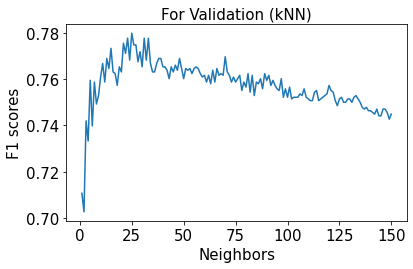

In [33]:
plt.figure()
plt.ylabel('F1 scores');
plt.xlabel('Neighbors');
all_sample_title = ('For Validation (kNN)')
plt.plot(krange,knn_gscv.cv_results_['mean_test_score'])
plt.tight_layout()
plt.title(all_sample_title, y=1.1);
plt.tight_layout()
#plt.savefig('sav_images/p2knn.svg',transparent=True)
plt.show()


**AD versus CN versus MCI in 3 years
The task is not to diagnose the status from the other value at the same visit, but to split the individual visits into past and future ones. Any variables from the past to predict the status (CN, AD or MCI) of the patients 3 years ahead of time is taken**